# Automatic, Advanced Canny Edge Detector 

본 프로젝트에서는 cv2.Canny() edge detector의 아래와 같은 문제점을 개선하여, 더 강력한 edge detector를 만들고자 합니다.
1. Canny edge detector는 두 개의 threshold를 지정해 주어야 합니다. 이 프로젝트에서는 대부분의 경우 parameter를 변경할 필요 없이 준수한 성능을 보이는 알고리즘을 만들고자 합니다.
2. Canny edge detector는 많은 경우 threshold가 다소 두껍게 나타나는 경향이 있습니다. 이 프로젝트에서는 edge 구조를 유지하면서도, 최대한 얇은 선을 그리도록 합니다.

본 프로젝트에서 구현된 알고리즘은 다음의 장점을 가집니다.
1. Image에 gaussian blur를 적용하기 전에, histogram equalization을 먼저 적용하여 이미지의 대비를 적절히 증가시켜 edge detection이 용이하도록 합니다.
2. Double thresholding 과정에 Otsu's method를 사용하여, 자동화된 thresholding이 가능하도록 합니다.
3. Edge linking 과정에서 search range를 조정 가능하며, 세부적인 구현도 다소 상이합니다.
4. Point에 해당하는 부분이 edge로 잘못 선택되는 경우를 보정하기 위해, `ignore_isolated_value()` method를 도입하여 post processing을 수행합니다.

## Files
본 프로젝트는 아래의 파일 구조로 이루어져 있습니다.
1. /dataset : Edge detection을 위해 사용된 사진 파일들이 저장되어 있습니다.
2. edge_linker, gaussian_blur, histogram_equalization, non_maximum_suppression, thresholding : 본 프로젝트의 canny edge detector를 구현하기 위해 필요한 여러 utility들을 테마별로 나누어 놓았습니다.
3. utils.py : 여러 코드에서 global하게 사용되는 utility들이 구현되어 있습니다.

우선 구현에 필요한 package들을 import 합니다.  
본 project에서는 다음의 package들이 사용되었으며, 이외의 package는 사용되지 않았습니다.
1. PIL
2. Numpy
3. Matplotlib (중간 결과 시각화를 위해 사용)
4. cv2.Canny (결과 비교를 위해서만 사용되었으며, 구현 과정에 포함되지 않습니다)

## Notice
edge_linker, non_maximum_suppression, thresholding package에서는 본 프로젝트에서 최종적으로 선택된 방법들이 아닌, 착안 과정에서 구현된 여러 다른 방식의 method들도 존재합니다.  
해당 함수들은 "구현 중에 이렇게 많은 생각들을 했구나~" 라는 것을 알아주셨으면 하는 마음으로, 굳이 삭제하지 않았습니다. 

In [1]:
from PIL import Image
from cv2 import Canny # cv2.Canny()와의 비교를 위해서만 사용되었습니다.
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import *
import gaussian_blur
import histogram_equalization
import non_maximum_suppression
import thresholding
import edge_linker


os.chdir("/Users/healingmusic/Programming/edge_detector")

이미지 import하고, gray scale로 변경합니다.  
본 프로젝트에서는 Y channel에서 edge detection을 수행한 결과만을 활용하도록 하였습니다.  
추가로 resize를 통해 연산복잡도를 조정하였습니다.   

**dataset의 이미지들 중 kozel, pilsner는 제가 직접 촬영한 이미지들입니다. 구현 과정에서는 주로 kozel을 사용하였습니다.**

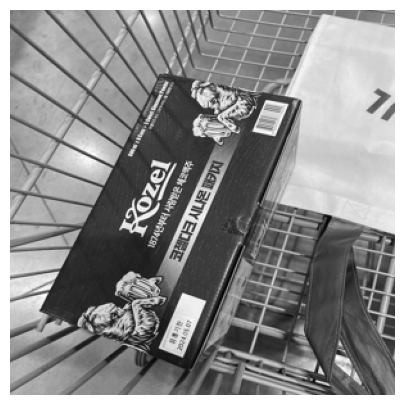

In [2]:
image_path = "dataset/kozel.png"
image_gray = Image.open(image_path).convert("L")
image_original = np.array(image_gray)
image_original = resize(image_original, 300, 300)

show(image_original)

## Histogram Equalization

제 구현 방식의 original idea 중 하나입니다.  
Histogram equalization을 적용하였는데, 이는 이미지의 대비를 적절히 증가시켜서 edge detection에 유리하도록 하기 위함입니다.  
Sharpening을 인위적으로 수행하지 않은 이유는, sharpening을 수행하는 경우 edge가 아닌 부분의 gradient도 크게 증폭되어서 edge detection의 정확도가 떨어지기 쉽기 때문입니다.

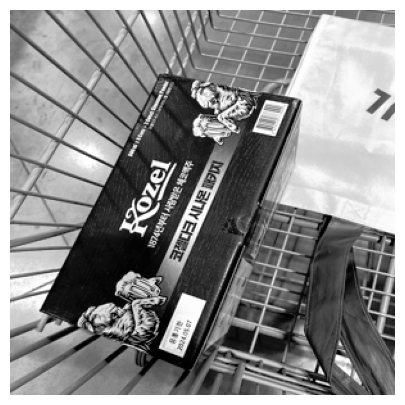

In [3]:
# 1. Histogram Equalization
image_original = histogram_equalization.equalize_histogram(image_original)

show(image_original)

## Gaussian Blur

다음은 Gaussian blur를 수행합니다. 이는 canny edge detection의 일반적인 과정과 동일합니다.  
이때 gaussian kernel 생성 및 convolution의 전 과정에 걸쳐 직접 구현한 함수를 사용하였습니다.

In [4]:
# 2. Gaussian Blur
image_blurred = gaussian_blur.gaussian_blur(image_original, kernel_size=5, sigma = 1)

Histogram equalization, blurring이 적용된 이미지에 대해 gradient magnitude, direction을 계산합니다.  
이때 direction은 -pi ~ pi의 radian 단위를 사용합니다.

In [5]:
# 3. Gradient Calculation
gradient_magnitude, gradient_direction = calculate_gradient(image_blurred)

gradient_magnitude, direction의 분포를 시각화해 보았습니다

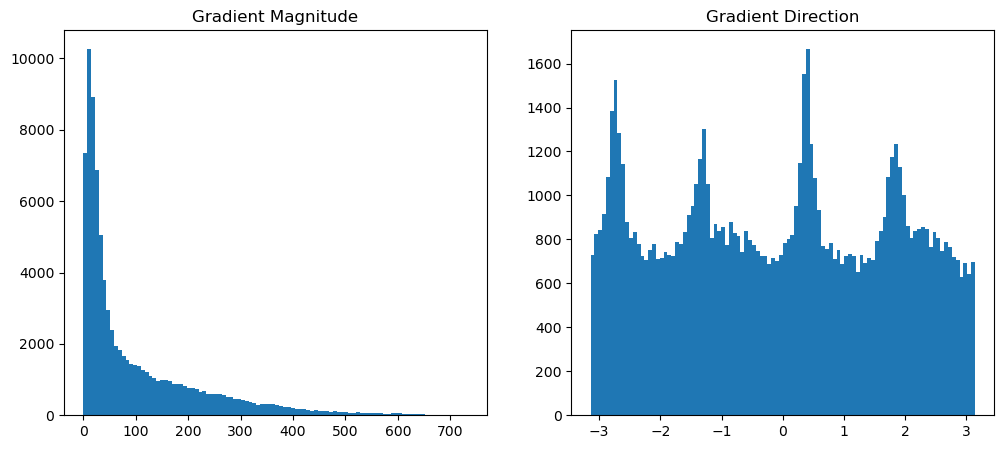

In [6]:
# Visualize distritbution of gradient magnitude & direction using histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(gradient_magnitude.flatten(), bins=100)
plt.title("Gradient Magnitude")
plt.subplot(1,2,2)
plt.hist(gradient_direction.flatten(), bins=100)
plt.title("Gradient Direction")
plt.show()

## Non-Maximum Suppression

Non-maximum Suppression을 수행하였습니다.  
이때 gradient의 방향을 8가지 방향으로 quantization하는 방법을 사용하지 않고, 정확성을 위해 edge가 지나는 방향의 양 픽셀의 값을 interpolation하는 방법을 수행하였습니다.

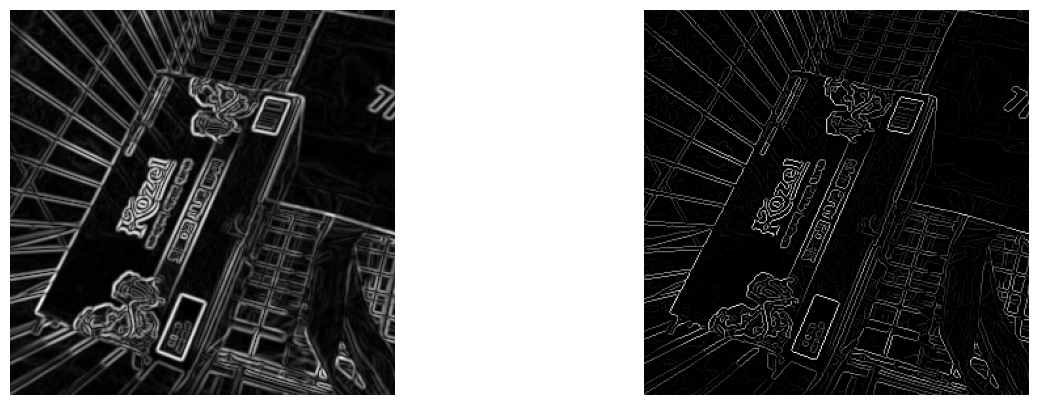

In [7]:
# 4. Non-Maximum Suppression
image_suppressed = non_maximum_suppression.non_maximum_suppression_interpolation(gradient_magnitude, gradient_direction)

show(gradient_magnitude, image_suppressed)

NMS가 적용된 결과 이미지의 gradient magnitude의 분포를 시각화해 보았습니다.  
해당 분포에 대해, 적절한 high, low threshold를 찾는 것이 thresholding의 관건이 됩니다.

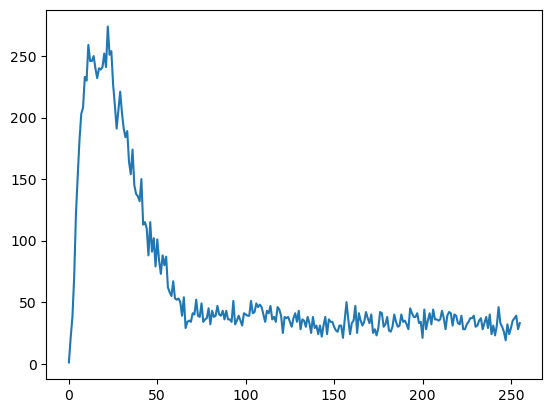

In [8]:
# histogram of image_suppressed
histogram = np.histogram(image_suppressed, bins=256, range=(0.01, 255))[0]
plt.plot(histogram)
plt.show()

추가적인 직관을 얻기 위해, 알고리즘 개발 과정에서 image_suppressed의 gradient magnitude, direction을 시각화하여 보았습니다.

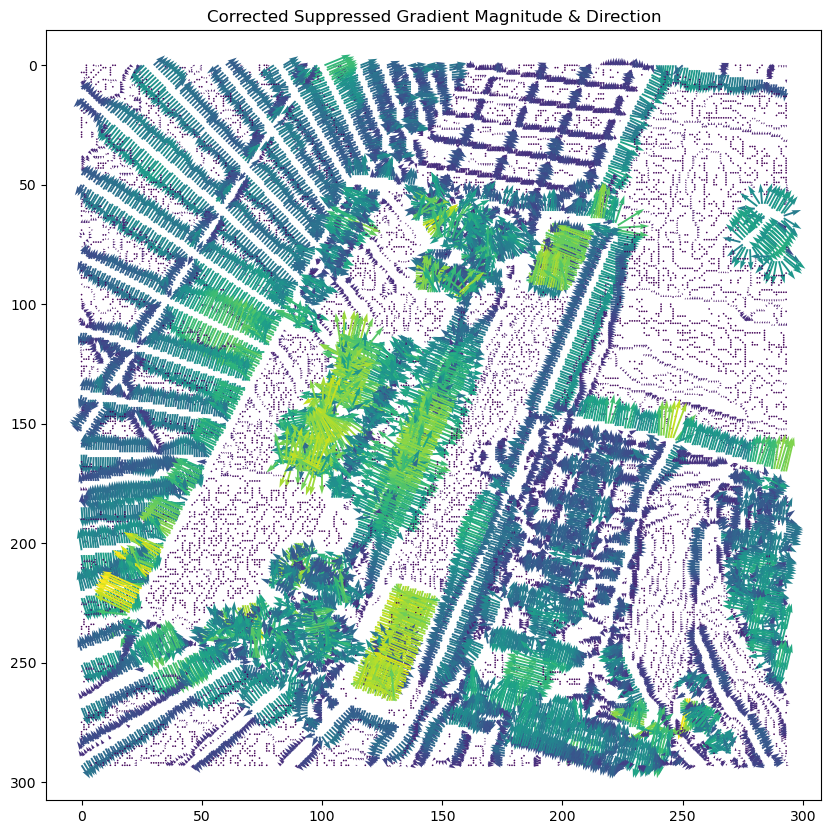

In [9]:
# gradient가 0이 아닌 지점에 대해, quiver plot을 이용하여 gradient magnitude & direction을 시각화하였습니다.

non_zero_indices = np.nonzero(image_suppressed)
non_zero_magnitude = gradient_magnitude[non_zero_indices]
non_zero_direction = gradient_direction[non_zero_indices]

U_non_zero = non_zero_magnitude * np.cos(non_zero_direction) / 40
V_non_zero = non_zero_magnitude * np.sin(non_zero_direction) / 40

plt.figure(figsize=(10, 10))
plt.quiver(non_zero_indices[1], non_zero_indices[0], U_non_zero, V_non_zero, non_zero_magnitude, angles='xy', scale_units='xy', scale=1)
plt.title("Corrected Suppressed Gradient Magnitude & Direction")
plt.gca().invert_yaxis()
plt.show()



## Double Thresholding

Thresholding 과정에서는 otsu's method를 통해 2개의 threshold를 얻는 방식을 사용하였습니다.  
이는 between-class variation을 극대화하는 otsu의 방식이 본 프로젝트에서 high / low threshold를 얻는 데에 적합하다고 생각하였기 때문입니다.

In [10]:
# 5. Double Thresholding
low_threshold, high_threshold = thresholding.otsu_two_thresholds(image_suppressed)

Otsu's method를 통해 선택된 두 threshold의 위치를 시각화하여 보았습니다.  
histogram은 image_suppressed의 gradient들 중 0이 아닌 값들의 분포를 나타냅니다.

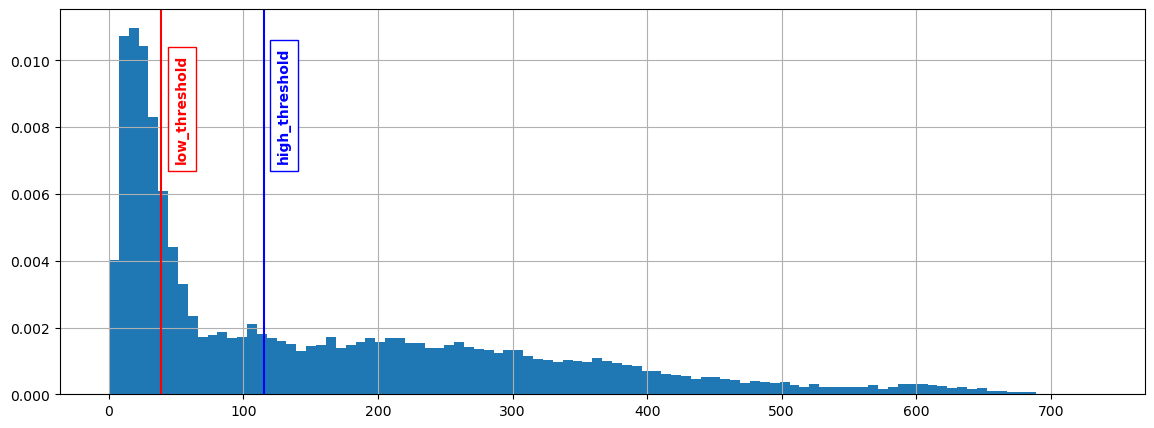

In [11]:
plt.figure(figsize=(14,5))
plt.hist(image_suppressed[image_suppressed != 0], range = (0, image_suppressed.max()), density=True, bins=100)
plt.grid()
plt.axvline(low_threshold, color='r')
plt.axvline(high_threshold, color='b')
plt.text(low_threshold + 10, 0.007, "low_threshold", rotation=90, color='r', fontweight='bold', bbox=dict(facecolor='white', edgecolor='red', pad=5.0))
plt.text(high_threshold + 10, 0.007, "high_threshold", rotation=90, color='b', fontweight='bold', bbox=dict(facecolor='white', edgecolor='blue', pad=5.0))
plt.show()

In [12]:
# 단순히 입력받은 두 threshold를 기준으로 strong edge와 weak edge를 구분하는 함수입니다.
strong_edges, weak_edges = thresholding.thresholding(image_suppressed, low_threshold, high_threshold)

## Edge Linking by Hysteresis

Edge linking을 통해 weak edge들 중 strong edge와 인접한 edge를 최종 edge로 추가합니다.  
이때 mask_size를 조절하여 더 넓은 범위에서 몇 개의 strong edge가 있는지 찾을 수 있도록 구현되어 있습니다.  
다만 canny의 원래 구현 방식에 비해 다른 점이 존재합니다.  

우선 edge의 방향과 일치하는 픽셀들이 아니라, edge에 수직한 방향(gradient 방향)에 위치한 픽셀만 제외한 모든 픽셀들을 neighbor로 설정하였습니다.  
edge 방향에 평행한 픽셀들을 neighbor로 설정하는 경우에는 gradient 방향을 8방향으로 quantization하여 해당 방향에서의 neighbor를 찾는 방식을 사용하여야 되는데, 이 경우 실제 이미지에서 실제 이웃한 edge가 제대로 선택되지 않는 경우가 많을 것이라고 생각하였습니다.  
따라서 다소 기준이 널널한 방식으로, edge 방향에 수직한, 즉 너무 방향의 차이가 크지 않은 픽셀들은 모두 neighbor로 선택하였습니다. mask_size가 3인 경우 (=search range가 1), 총 8 - 2 = 6개의 픽셀들 중 strong edge가 존재하는지 탐색하게 됩니다.

다음으로 mask_size와 threshold_count를 설정 가능하도록 하였습니다. mask_size는 해당 픽셀을 중심으로 탐색하고자 하는 범위를 나타내는 것으로, mask_size // 2 = search_range라고 생각하시면 되겠습니다.   
threshold_count는 해당 범위 내에서 최소 몇 개의 strong edge가 존재해야 edge로 인정해주는지의 값을 의미합니다.  
기본값은 일반적인 Canny와 동일하게 mask_size = 3, threshold_count = 1로 설정되어 있습니다.

In [13]:
# 6. Edge Linking by Hysteresis
result = edge_linker.edge_linking_by_hysteresis(strong_edges, weak_edges, gradient_direction, mask_size=3, threshold_count = 1)

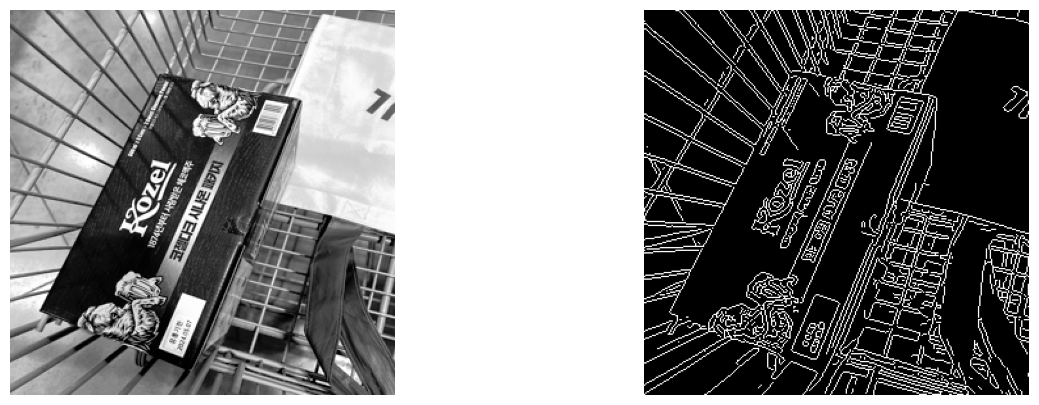

In [14]:
show(image_original, result)

## Ignore Isolated Value
본 과정은 현재까지 결정된 edge image (표준 Canny detector 기준으로는 최종 edge에 해당하는)에서 이따금씩 보이는 문제점을 해결하기 위한 post-processing에 해당합니다.  
때때로, 결과 이미지에서 edge에 해당하지 않는, 즉 오류에 해당하는 부분을 관찰해 보면, 다음의 사항에 해당하는 경우가 대부분입니다.

1. 열린 곡선 (다른 선과 이어져 있지 않은 짧은 선)
2. 점

위의 두 항목들은 공통적으로, 주변에 edge에 해당하는 pixel의 개수가 적다는 특징이 있습니다 (열린 곡선의 경우에는 선의 양 끝 지점).  
따라서, **이러한 '고립된' 선들을 제거하고 더 깔끔한 결과물을 얻기 위해 `ignore_isolated_value`라는 함수를 구현하였습니다.**

`ignore_isolated_value`는 다음과 같은 아이디어를 통해 구현되었습니다.  
* Edge에 해당하는 지점들을 순회하며, 해당 pixel 기준 상하좌우 search_range 만큼의 범위 내에 몇 개의 edge가 존재하는지 확인합니다.  
* 진정한 edge인 경우, 최소 search_range * 2 + 1개는 존재해야 할 것입니다 (단, 실제 적용 상의 오차를 고려하여 search_range * 2를 threshold로 설정하였습니다).  
* 해당 값보다 작은 개수의 neighborhood를 가진 edge pixel은 edge에서 drop합니다.
* search_range를 여러 가지로 달리해 가며, 여러 방면에서 "진정한" edge가 아닌 지점을 탐색합니다.
* 참고) 해당 과정은 결과물 품질 향상 폭에 비해 연산량이 많으므로, 꼭 수행되어야 하는 과정에 해당하지는 않는다고 생각합니다.
* 참고) 해당 과정을 지나치게 많이 수행하는 경우, edge에 해당하는 부분도 가장자리부터 서서히 잘려나가는 현상이 강하게 보일 수 있습니다.

In [15]:
# 7. Postprocessing
result_postprocessed = ignore_isolated_value(result, search_range=1)
result_postprocessed = ignore_isolated_value(result_postprocessed, search_range=2)
result_postprocessed = ignore_isolated_value(result_postprocessed, search_range=3)
result_postprocessed = ignore_isolated_value(result_postprocessed, search_range=4)

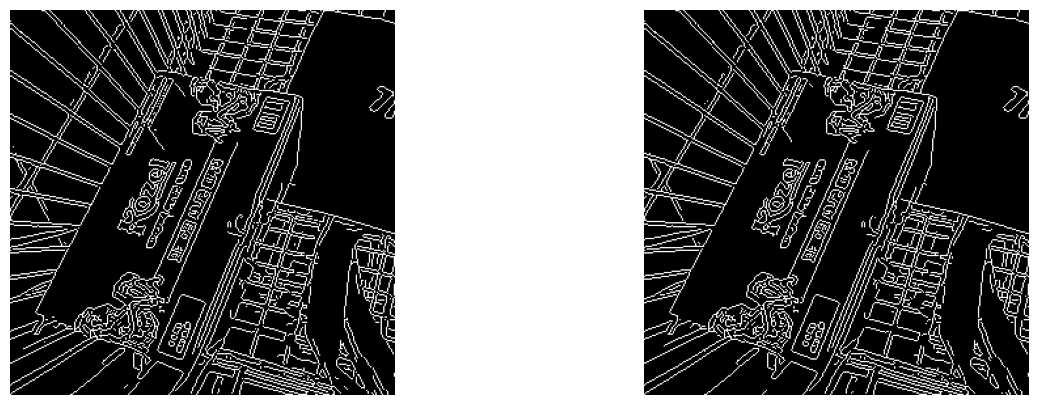

In [16]:
show(result, result_postprocessed)

## 결과 비교

cv2.Canny와의 결과를 비교합니다.  
cv2.Canny의 결과에 비해 edge는 더 얇으면서도, 비슷하거나 더 나은 수준의 edge detection 성능을 보유합니다.  

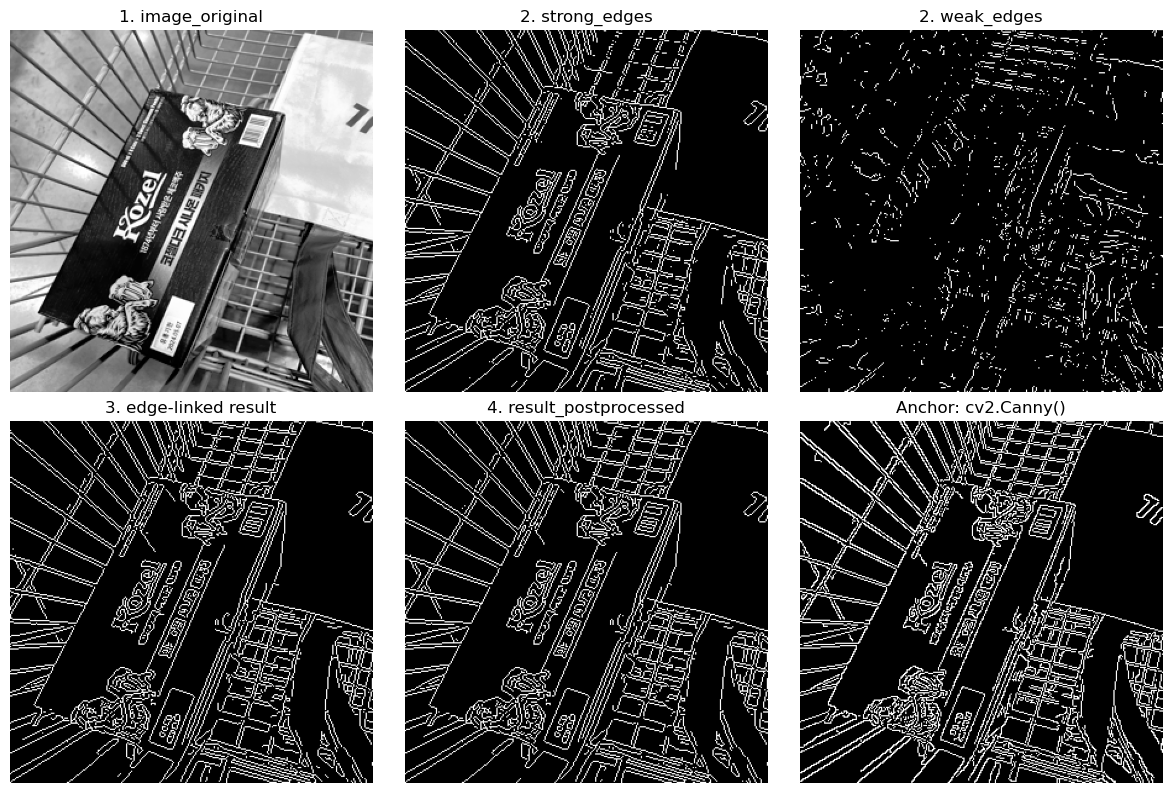

In [17]:
# Visualize these 6 images with title
# image_original, strong_edges, weak_edges, result
# Canny(image_original, 100, 300), result_postprocessed

titles = ['1. image_original', '2. strong_edges', '2. weak_edges', '3. edge-linked result', '4. result_postprocessed', 'Anchor: cv2.Canny()',]
images = [image_original, strong_edges, weak_edges, result, result_postprocessed, Canny(image_original, 100, 300)]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


모든 과정을 하나의 함수로 정리합니다.

In [18]:
def advanced_edge_detector(image):
    image = histogram_equalization.equalize_histogram(image)
    image = gaussian_blur.gaussian_blur(image)
    gradient_magnitude, gradient_direction = calculate_gradient(image)
    image_suppressed = non_maximum_suppression.non_maximum_suppression_interpolation(gradient_magnitude, gradient_direction)
    low_threshold, high_threshold = thresholding.otsu_two_thresholds(image_suppressed)
    strong_edges, weak_edges = thresholding.thresholding(image_suppressed, low_threshold, high_threshold)
    result = edge_linker.edge_linking_by_hysteresis(strong_edges, weak_edges, gradient_direction)
    result_postprocessed = ignore_isolated_value(result, search_range=1)
    result_postprocessed = ignore_isolated_value(result, search_range=2)
    result_postprocessed = ignore_isolated_value(result, search_range=3)
    result_postprocessed = ignore_isolated_value(result, search_range=4)
    return result_postprocessed

dataset 폴더 내의 모든 이미지에 대해 advanced_edge_detector()를 적용합니다.  
이후 결과를 dataset_edge 폴더 내에 저장합니다.

In [19]:
os.chdir("/Users/healingmusic/Programming/edge_detector")
image_folder_path = "dataset"
image_folder = os.listdir(image_folder_path)
image_folder.sort()

for image_name in image_folder:
    image_path = os.path.join(image_folder_path, image_name)
    if image_name == ".DS_Store":
        continue
    image = Image.open(image_path).convert("L")
    image = np.array(image)
    result = advanced_edge_detector(image)
    result = Image.fromarray(result)
    result.save("dataset_edge/" + image_name)
    print(image_name, "is saved.")

cameraman.png is saved.
kozel.png is saved.
pilsner.png is saved.


모든 이미지에 대해 처리된 결과를 시각화합니다.

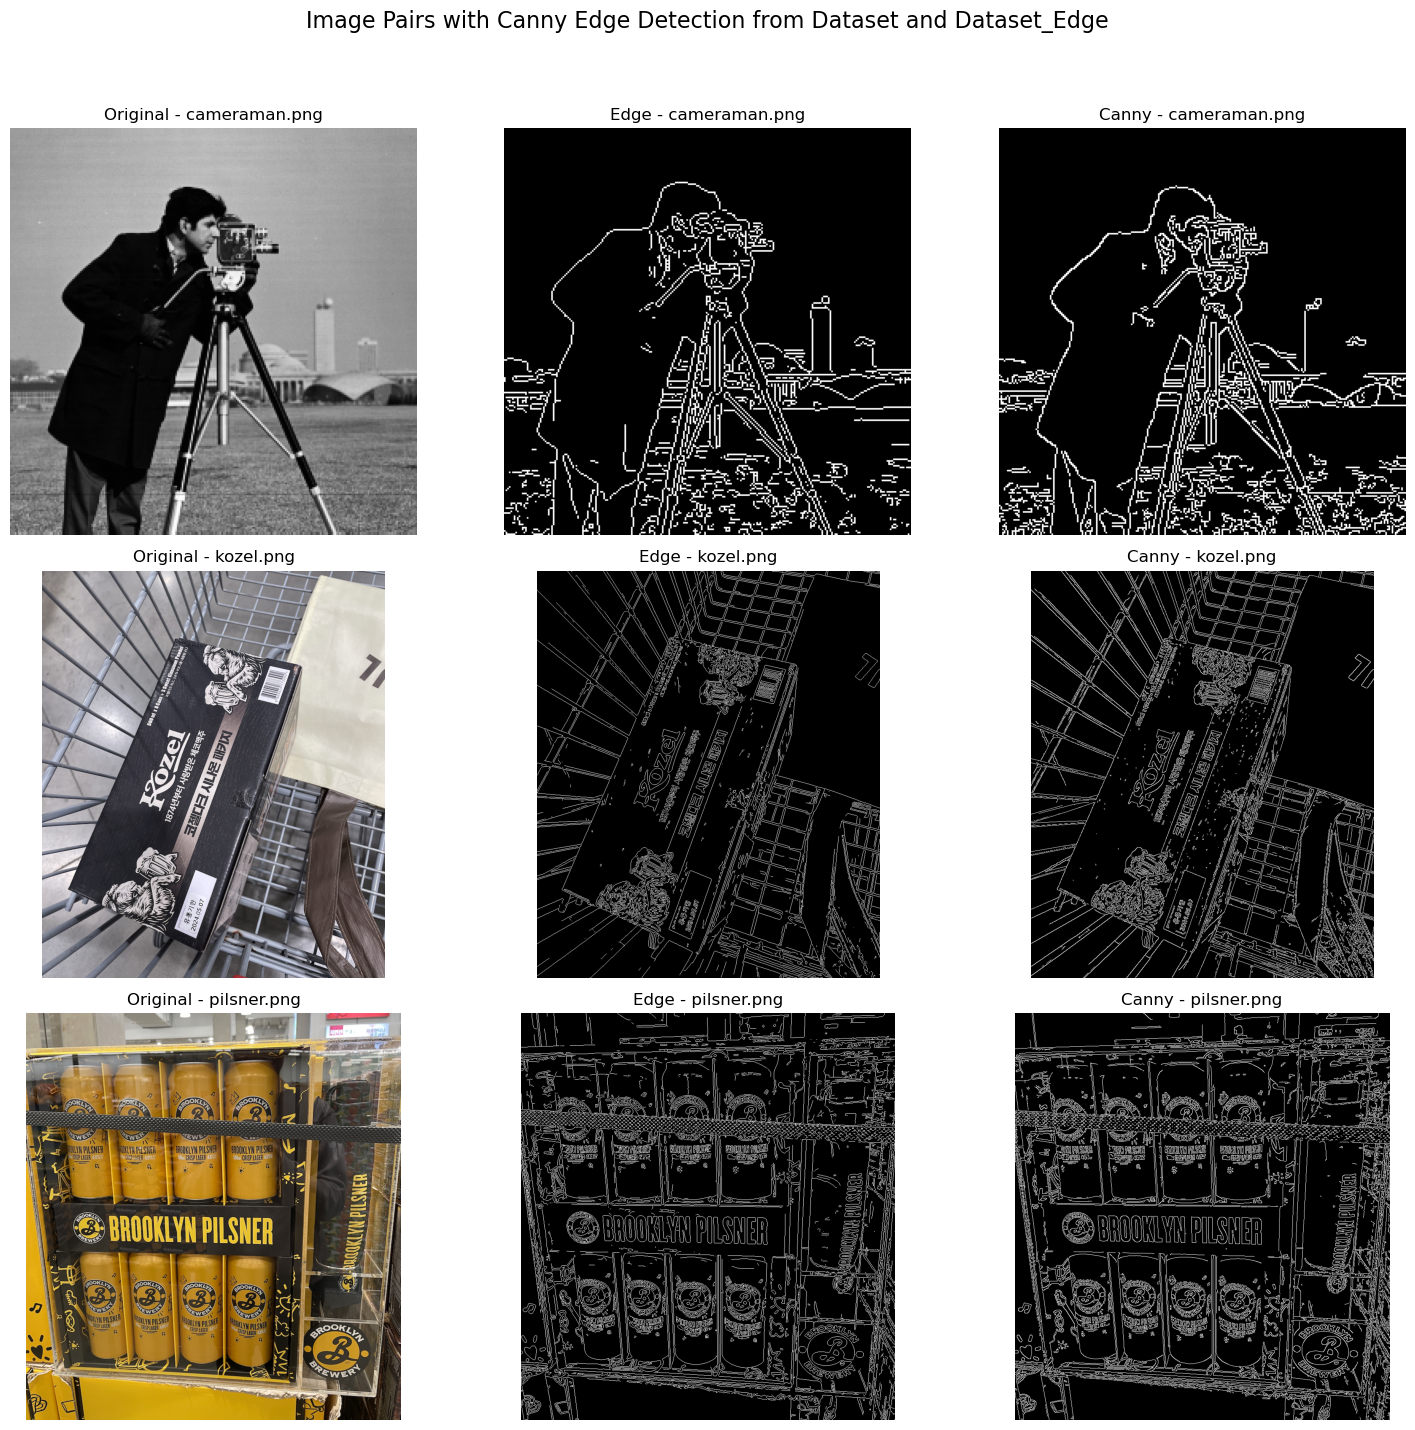

In [20]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

dataset_folder = 'dataset'
edge_folder = 'dataset_edge'

# Retrieve image file names, excluding '.DS_Store'.
images = [f for f in os.listdir(dataset_folder) if f.endswith('.png') or f.endswith('.jpg')]
edge_images = [f for f in os.listdir(edge_folder) if f.endswith('.png') or f.endswith('.jpg')]

# Find and sort common file names.
common_images = sorted(set(images) & set(edge_images))

# Determine the number of rows and columns for subplots.
num_images = len(common_images)
num_cols = 3  # Three columns (original image, edge image, and Canny edge detection result)
num_rows = num_images

# Create subplots.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_images * 5))

# Iterate over each image pair for visualization.
for idx, img_name in enumerate(common_images):
    img_path = os.path.join(dataset_folder, img_name)
    edge_img_path = os.path.join(edge_folder, img_name)

    original_img = Image.open(img_path)
    edge_img = Image.open(edge_img_path)

    # Convert the original image to grayscale for Canny edge detection
    original_img_gray = np.array(original_img.convert('L'))
    canny_edges = cv2.Canny(original_img_gray, 100, 200)

    # Display the images in subplots.
    if num_images > 1:
        axes[idx, 0].imshow(original_img, cmap='gray')
        axes[idx, 1].imshow(edge_img, cmap='gray')
        axes[idx, 2].imshow(canny_edges, cmap='gray')

        # Set titles for each column
        axes[idx, 0].set_title(f'Original - {img_name}')
        axes[idx, 1].set_title(f'Edge - {img_name}')
        axes[idx, 2].set_title(f'Canny - {img_name}')

        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')
    else:
        axes[0].imshow(original_img, cmap='gray')
        axes[1].imshow(edge_img, cmap='gray')
        axes[2].imshow(canny_edges, cmap='gray')

        # Set titles for each column
        axes[0].set_title(f'Original - {img_name}')
        axes[1].set_title(f'Edge - {img_name}')
        axes[2].set_title(f'Canny - {img_name}')

        axes[0].axis('off')
        axes[1].axis('off')
        axes[2].axis('off')

# Set the super title for the entire figure
fig.suptitle('Image Pairs with Canny Edge Detection from Dataset and Dataset_Edge', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
